In [1]:
import xarray as xr
import numpy as np
import mlflow
import matplotlib.pyplot as plt
import seaborn as sns
import os
import os.path
from urllib.request import urlretrieve

In [2]:
# The NetCDF file is about 228 MB
CCSM4_NC_FILENAME = 'data/cmip5_rcp26_CCSM4.nc'
if not os.path.exists(CCSM4_NC_FILENAME):
    print('Downloading CMIP5 CCSM4 data ...')
    os.makedirs('data/')
    urlretrieve('https://storage.googleapis.com/cmip5-monthly/rcp26/CCSM4/rcp26_CCSM4_grid.nc', CCSM4_NC_FILENAME)
    print('Done')
else:
    print('Found existing data file: {}'.format(CCSM4_NC_FILENAME))

Found existing data file: data/cmip5_rcp26_CCSM4.nc


In [3]:
ccsm4_ds = xr.load_dataset(CCSM4_NC_FILENAME)
ccsm4_ds

<xarray.Dataset>
Dimensions:  (lat: 72, lon: 144, time: 2880)
Coordinates:
    months   (time) object 'Jan' 'Feb' 'Mar' 'Apr' ... 'Sep' 'Oct' 'Nov' 'Dec'
    years    (time) int32 1861 1861 1861 1861 1861 ... 2100 2100 2100 2100 2100
  * lon      (lon) float64 1.25 3.75 6.25 8.75 11.25 ... 351.2 353.8 356.2 358.8
  * lat      (lat) float64 -88.75 -86.25 -83.75 -81.25 ... 83.75 86.25 88.75
Dimensions without coordinates: time
Data variables:
    tas      (time, lat, lon) float64 -1.763 -1.999 -1.91 ... 5.433 5.415 5.4

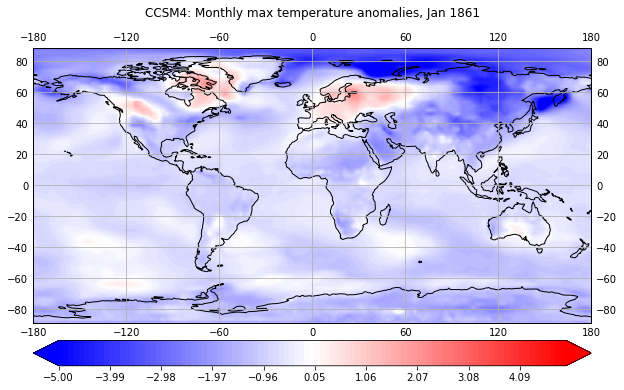

In [4]:
def plot_geo_heatmap(X, lats, lons, cmap="viridis", figsize=(8,6), title='', min_max=None,  bins=100, gridlines=False):
    import cartopy.crs as ccrs
    from cartopy.util import add_cyclic_point
    X = X.squeeze()
    assert len(X.shape) == 2
    # removes dicontinuity in longitude
    X, lons = add_cyclic_point(X, coord=lons)
    proj = ccrs.PlateCarree()
    fig = plt.figure(figsize=figsize)
    ax = plt.axes(projection=proj)
    ax.set_extent([lons[0], lons[-1], lats[0], lats[-1]], proj)
    min_val, max_val = (min_max[0], min_max[1]) if min_max is not None else (np.nanmin(X), np.nanmax(X))
    breaks = np.linspace(min_val-1.0E-5, max_val+1.0E-5, bins)
    cs = ax.contourf(lons, lats, X, breaks, cmap=cmap, transform=proj, extend='both')
    cbar = plt.colorbar(cs, ax=ax, orientation='horizontal', pad=0.04)
    ax.coastlines()
    if gridlines:
        ax.gridlines(crs=proj, draw_labels=True)
        ax.set_title(title, y=1.09)
    else:
        ax.set_title(title)

t = 0
plot_geo_heatmap(ccsm4_ds['tas'][t], ccsm4_ds.lat, ccsm4_ds.lon, figsize=(10,8), cmap='bwr', min_max=(-5,5), gridlines=True)
plt.title('CCSM4: Monthly max temperature anomalies, {} {}'.format(ccsm4_ds.months[t].values, ccsm4_ds.years[t].values))
plt.show()

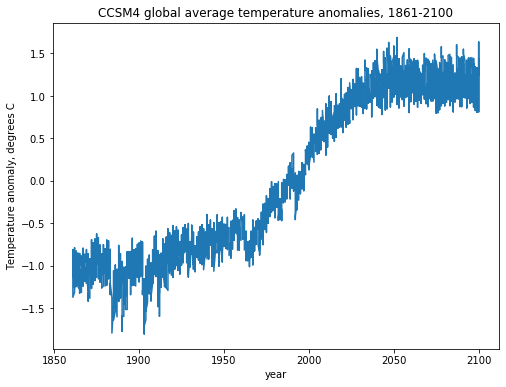

In [5]:
# average global temperature anomalies over time
nw_na_series = ccsm4_ds['tas'].mean(dim=['lat', 'lon'])
# plot the series
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(nw_na_series.years, nw_na_series)
years = np.unique(nw_na_series.years.values)
plt.title('CCSM4 global average temperature anomalies, 1861-2100')
plt.xlabel('year')
plt.ylabel('Temperature anomaly, degrees C')
plt.show()

In [ ]:
lasso_run = mlflow.run('.', 'lasso', experiment_name='ccsm4-lasso',
                       parameters={'data_file': CCSM4_NC_FILENAME}, use_conda=False)

In [ ]:
cnn_run = mlflow.run('.', 'cnn', experiment_name='ccsm4-cnn',
                     parameters={'data_file': CCSM4_NC_FILENAME}, use_conda=False)